## Testing Watershed Segmentation - Deep Learning

In [50]:
%matplotlib inline

import datetime
import os

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from collections import defaultdict
from typing import Dict, List

from IPython.display import Image
from skimage import io
from skimage import transform
from skimage import color
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
from tensorflow.keras import backend as K

In [53]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [54]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [48]:
# Optimisations
tf.config.optimizer.set_jit(True)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [15]:
image_path: str = "../Leaf_Dataset/images"
mask_path: str = "../Leaf_Dataset/masks"
images: List[str] = sorted(os.listdir(image_path))
images = [f"{image_path}/{i}" for i in images]
masks: List[str] = sorted(os.listdir(mask_path))
masks = [f"{mask_path}/{m}" for m in masks]

In [16]:
images[:15]

['../Leaf_Dataset/images/plant00001.png',
 '../Leaf_Dataset/images/plant00002.png',
 '../Leaf_Dataset/images/plant00003.png',
 '../Leaf_Dataset/images/plant00004.png',
 '../Leaf_Dataset/images/plant00005.png',
 '../Leaf_Dataset/images/plant00006.png',
 '../Leaf_Dataset/images/plant00007.png',
 '../Leaf_Dataset/images/plant00008.png',
 '../Leaf_Dataset/images/plant00009.png',
 '../Leaf_Dataset/images/plant00010.png',
 '../Leaf_Dataset/images/plant00011.png',
 '../Leaf_Dataset/images/plant00012.png',
 '../Leaf_Dataset/images/plant00013.png',
 '../Leaf_Dataset/images/plant00014.png',
 '../Leaf_Dataset/images/plant00015.png']

## Train Test Split

In [17]:
#Total images are 810
#Going for 80-10-10 split

X_train, X_test, y_train, y_test = train_test_split(images,
                                                    masks,
                                                    shuffle=True,
                                                    test_size=0.20)
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                shuffle=True,
                                                test_size=0.50)

In [18]:
X_train[:10]

['../Leaf_Dataset/images/plant06759.png',
 '../Leaf_Dataset/images/plant06643.png',
 '../Leaf_Dataset/images/plant07131.png',
 '../Leaf_Dataset/images/plant08129.png',
 '../Leaf_Dataset/images/plant01589.png',
 '../Leaf_Dataset/images/plant01070.png',
 '../Leaf_Dataset/images/plant07202.png',
 '../Leaf_Dataset/images/plant04201.png',
 '../Leaf_Dataset/images/plant00192.png',
 '../Leaf_Dataset/images/plant06849.png']

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Load Image from Paths and Data Augmentation

In [26]:
# Load the images and masks from paths
@tf.function
def get_images_and_masks(image_path, mask_path):
    image = tf.io.decode_png(tf.io.read_file(image_path), channels = 3)
    mask = tf.io.decode_png(tf.io.read_file(mask_path), channels = 1)
    image = tf.image.convert_image_dtype(image, tf.float64)
    mask = tf.image.convert_image_dtype(mask, tf.float64)
    # Resizing
    image = tf.image.resize(image, [224, 224])
    mask = tf.image.resize(mask, [224, 224])
    return image, mask


# Data augmentation
@tf.function
def data_augmentation(image, mask):
    random_number = tf.random.uniform(shape = [], maxval = 5, dtype = tf.int32)
    
    # ==1 then apply rotation
    if tf.equal(random_number, tf.constant(1)):
        image, mask = rotate_image(image, mask)
        
    # ==2 then apply horizontal flip
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = random_horizontal_flip(image, mask)
        
    # ==3 then apply vertical flip
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = random_vertical_flip(image, mask)
            
    # ==4 then apply gaussian blur
    elif tf.equal(random_number, tf.constant(1)):
        #image, mask = gaussian_blur(image, mask)
        pass # Since current environment version does not support the tf gaussian blur function
        
    # ==5 No augmentation
    else:
        pass
    
    return image, mask


# Augmentation helpers
#https://stackoverflow.com/a/53780220/11916806
'''@tf.function
def gaussian_blur(image, mask):
    image = tfa.image.gaussian_filter2d(image, filter_shape = 100, sigma = 16.6, padding = "SYMMETRIC")
    return image, mask'''

# Functions to flip images(50% chance)
@tf.function
def random_horizontal_flip(image, mask):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value, lambda: tf.image.flip_left_right(image), lambda: image)
    mask = tf.cond(cond_value, lambda: tf.image.flip_left_right(mask), lambda: mask)
    return image, mask

@tf.function
def random_vertical_flip(image, mask):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value, lambda: tf.image.flip_up_down(image), lambda: image)
    mask = tf.cond(cond_value, lambda: tf.image.flip_up_down(mask), lambda: mask)
    return image, mask

# Function to rotate images by 4 degrees
@tf.function
def rotate_image(image, mask):
    image = tfa.image.rotate(image, 4, interpolation = "NEAREST")
    mask = tfa.image.rotate(mask, 4, interpolation = "NEAREST")
    return image, mask

In [27]:
train_dataset = train_dataset.map(get_images_and_masks).map(data_augmentation)
val_dataset = val_dataset.map(get_images_and_masks)
test_dataset = test_dataset.map(get_images_and_masks)

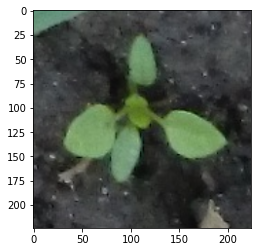

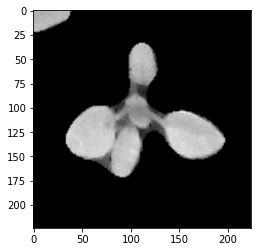

--------------------------------------------------


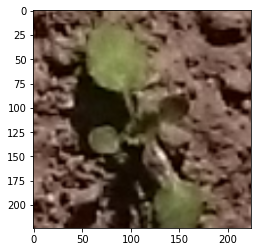

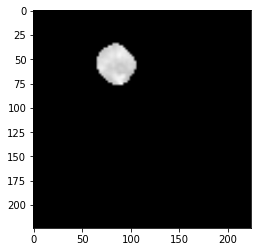

--------------------------------------------------


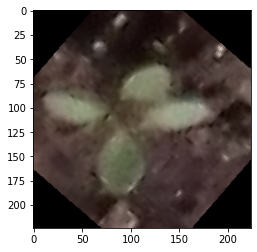

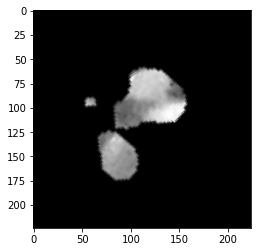

--------------------------------------------------


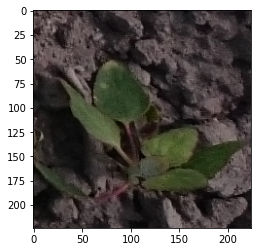

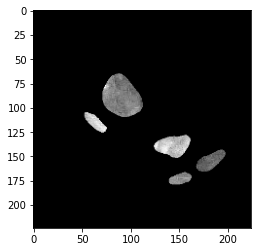

--------------------------------------------------


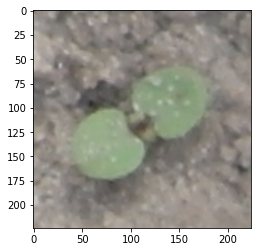

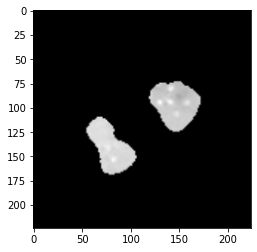

--------------------------------------------------


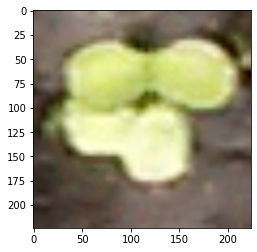

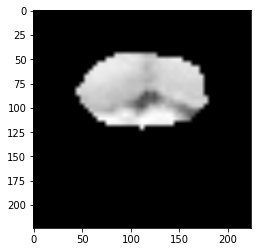

--------------------------------------------------


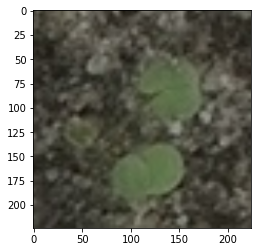

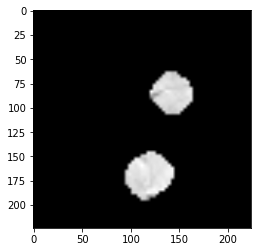

--------------------------------------------------


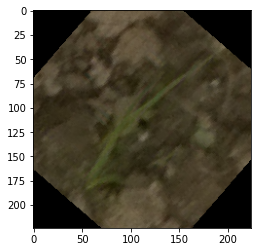

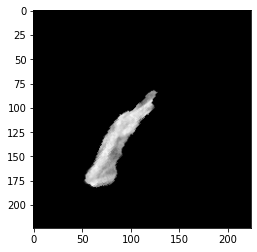

--------------------------------------------------


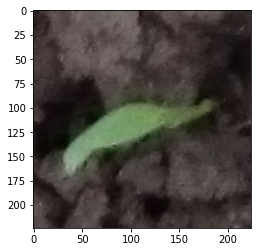

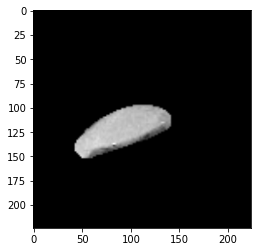

--------------------------------------------------


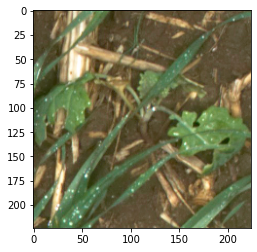

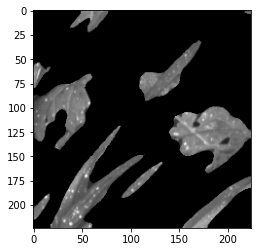

--------------------------------------------------


In [28]:
# Just a check
for image, mask in train_dataset.take(10):
    plt.imshow(image.numpy())
    plt.show()
    plt.imshow(np.reshape(mask.numpy(), (224,224)), cmap = 'gray')
    plt.show()
    print("-"*50)

## Hyperparams, Repeat, and Batching

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 150
repeat_count = None

In [30]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)

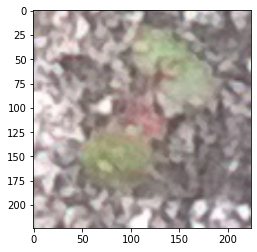

(224, 224, 3)
Red
Max value: 1.0
Min value: 0.3393592
Green
Max value: 1.0
Min value: 0.2975693
Blue
Max value: 1.0
Min value: 0.2887284
--------------------------------------------------


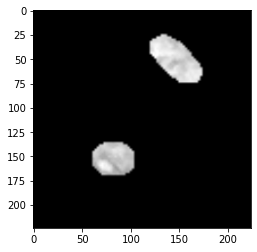

Max:  0.7803352
Min: 0.0


In [31]:
# Checking if all pixel values are between 0 and 1

for image, mask in train_dataset.take(1):
    #output = segnet_model(image)
    plt.imshow(image[0].numpy())
    plt.show()
    print(image[0].shape)
    print("Red")
    print("Max value:", np.max(image[0, :, :, 0].numpy()))
    print("Min value:", np.min(image[0, :, :, 0].numpy()))
    print("Green")
    print("Max value:", np.max(image[0, :, :, 1].numpy()))
    print("Min value:", np.min(image[0, :, :, 1].numpy()))
    print("Blue")
    print("Max value:", np.max(image[0, :, :, 2].numpy()))
    print("Min value:", np.min(image[0, :, :, 2].numpy()))
    print("-"*50)
    plt.imshow(np.reshape(mask[0].numpy(),(224,224)), cmap = "gray")
    plt.show()
    print("Max: ", np.max(np.reshape(mask[0].numpy(),(224,224))))
    print("Min:", np.min(np.reshape(mask[0].numpy(),(224,224))))

## Segmentation Model
This is a SegNet implementation

In [34]:
# Making custom layers for Maxpooling and Unpooling with indices
# Ref: https://github.com/ykamikawa/tf-keras-SegNet/blob/c69e4f1f85c626b919269d6748b67f7d9726e82f/layers.py#L5

class MaxPoolingWithArgmax2D(layers.Layer):
    def __init__(self, pool_size = (2,2), strides = (2,2), padding = "same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.strides = strides
        self.pool_size = pool_size
        
    # Define the layer logic in call function
    def call(self, inputs):
        padding = self.padding
        strides = self.strides
        pool_size = self.pool_size
        
        if K.backend() == "tensorflow":
            # Using tf.nn.max_pool_with_argmax for maxpooling operation
            # Adding 1 at end and start 
            # since we need to specify window size for each dimension (i.e batch, height, width, channel)
            ksize = [1, pool_size[0], pool_size[1], 1]
            # same for strides as well
            strides = [1, strides[0], strides[1], 1]
            padding = padding.upper()
            
            output, argmax = tf.nn.max_pool_with_argmax(
                inputs, 
                ksize = ksize,
                strides = strides,
                padding = padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)

        return [output, argmax]

    
# https://github.com/yselivonchyk/Tensorflow_WhatWhereAutoencoder/blob/master/pooling.py
def unpool(pool, indices, pool_size = (2,2), scope = 'unpool'):
    with tf.compat.v1.variable_scope(scope):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1]*pool_size[0], input_shape[2]*pool_size[1], input_shape[3]]
        #batch_shape = tf.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
        
        # Flatten the pool and output based on their corresponding shapes
        flat_input_size = tf.reduce_prod(input_shape)
        #flat_input_size = tf.math.cumprod(input_shape)[-1]
        flat_output_shape = [output_shape[0], output_shape[1]*output_shape[2]*output_shape[3]]
        
        pool_values = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype = indices.dtype), shape = [input_shape[0], 1, 1, 1])
        
        # Create indices from flattened array i.e. unravelling the indices from maxpooling
        b = tf.ones_like(indices) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        indices_ = tf.reshape(indices, [flat_input_size, 1])
        indices_ = tf.concat([b1, indices_], 1)
    
        # Fill the tensor with specific indices returned from corresponding max pool layer with the pool(output) values
        return_tensor = tf.scatter_nd(indices_, pool_values, shape = tf.cast(flat_output_shape, tf.int64))
        # Reshape to fit the return output shape
        return_tensor = tf.reshape(return_tensor, output_shape)
        
        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1]*pool_size[0], set_input_shape[2]*pool_size[1], set_input_shape[3]]
        return_tensor.set_shape(set_output_shape)
        return return_tensor
        
class MaxUnpooling2D(layers.Layer):
    def __init__(self, pool_size = (2,2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs, output_shape = None):
        pool = inputs[0] # This is the output from previous layer
        indices = tf.cast(inputs[1], dtype = tf.int64) # indices from the corresponding pooling layer
        return unpool(pool, indices, self.pool_size)

In [35]:
def Conv_BN_relu(input_tensor, filters):
    conv = layers.Convolution2D(filters, (3,3), padding = "same")(input_tensor)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("relu")(conv)
    return conv

In [39]:
input = layers.Input(shape=(224, 224, 3))

# Convolutions -- Encoder part
conv1 = Conv_BN_relu(input, 32)
conv2 = Conv_BN_relu(conv1, 32)
pool_1, argmax_1 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv2) # Shape = (112, 112, 32)

conv3 = Conv_BN_relu(pool_1, 64)
conv4 = Conv_BN_relu(conv3, 64)
pool_2, argmax_2 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv4) # Shape = (56, 56, 64)

conv5 = Conv_BN_relu(pool_2, 128)
conv6 = Conv_BN_relu(conv5, 128)
conv7 = Conv_BN_relu(conv6, 128) 
pool_3, argmax_3 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv7) # Shape = (28, 28, 128)

conv8 = Conv_BN_relu(pool_3, 256)
conv9 = Conv_BN_relu(conv8, 256)
conv10 = Conv_BN_relu(conv9, 256)
pool_4, argmax_4 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv10) # Shape = (14, 14, 256)

conv9 = Conv_BN_relu(pool_4, 512)
conv10 = Conv_BN_relu(conv9, 512)
conv11 = Conv_BN_relu(conv10, 512)
pool_5, argmax_5 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv11) # Shape = (7, 7, 512)


# Deconvolutions -- Decoder part

unpool_1 = MaxUnpooling2D(pool_size = (2, 2))([pool_5, argmax_5]) # Shape = (14, 14, 512)
conv12 = Conv_BN_relu(unpool_1, 512)
conv13 = Conv_BN_relu(conv12, 512)
conv14 = Conv_BN_relu(conv13, 256)                                # Shape = (28, 28, 256)

unpool_2 = MaxUnpooling2D(pool_size = (2, 2))([conv14, argmax_4]) 
conv15 = Conv_BN_relu(unpool_2, 256)
conv16 = Conv_BN_relu(conv15, 256)
conv17 = Conv_BN_relu(conv16, 128)                                # Shape = (56, 56, 128)

unpool_3 = MaxUnpooling2D(pool_size = (2, 2))([conv17, argmax_3]) 
conv18 = Conv_BN_relu(unpool_3, 128)
conv19 = Conv_BN_relu(conv18, 128)
conv20 = Conv_BN_relu(conv19, 64)                                 # Shape = (112, 112, 64)

unpool_4 = MaxUnpooling2D(pool_size = (2, 2))([conv20, argmax_2]) 
conv21 = Conv_BN_relu(unpool_4, 64)
conv22 = Conv_BN_relu(conv21, 32)                                 # Shape = (224, 224, 32)

unpool_5 = MaxUnpooling2D(pool_size = (2, 2))([conv22, argmax_1]) 
conv24 = Conv_BN_relu(unpool_5, 32)

output = layers.Convolution2D(1, (1,1), padding = "same", activation="sigmoid")(conv24)


segnet_model = Model(inputs=[input], outputs=[output])
segnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

In [40]:
# Define the loss function

bce = tf.keras.losses.BinaryCrossentropy(from_logits= False)

In [41]:
# Setting up tensorboard 
# https://www.tensorflow.org/tensorboard/get_started

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [43]:
# Tensorboard

In [47]:
# Compile and train
tf.keras.backend.clear_session()
segnet_model.compile(
    loss = bce,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics= ['accuracy']
)

EPOCHS = 10

fit_history = segnet_model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [tensorboard_callback],
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    #initial_epoch = 5, # Not useful for training for the first time
    #use_multiprocessing = True
)

Epoch 1/10
  2/110 [..............................] - ETA: 1:31:55 - loss: 0.4443 - accuracy: 0.7962

KeyboardInterrupt: 

## Evaluation on Test Data

In [ ]:
segnet_model.evaluate(test_dataset)

In [ ]:
for image, mask in test_dataset:
    print("Predicted Mask")
    pred = segnet_model.predict(image)
    #print(pred[0])
    plt.imshow(np.reshape(pred[0], (224,224)), cmap="gray")
    plt.show()
    print("-"*50)
    print("Ground Truth")
    plt.imshow(np.reshape(mask[0].numpy(), (224,224)), cmap="gray")
    plt.show()
    print("-"*50)
    print("-"*50)

## Save the model

In [ ]:
segnet_model.save("saved_models/saved_segmentation_model")